In [413]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [414]:
dataset = 'model/keypoint_classifier/keypoint_video.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [415]:
NUM_CLASSES = 6

# 学習データ読み込み

In [416]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [417]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [419]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [420]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_39 (Dropout)        (None, 42)                0         
                                                                 
 dense_57 (Dense)            (None, 30)                1290      
                                                                 
 dropout_40 (Dropout)        (None, 30)                0         
                                                                 
 dense_58 (Dense)            (None, 20)                620       
                                                                 
 dropout_41 (Dropout)        (None, 20)                0         
                                                                 
 dense_59 (Dense)            (None, 10)                210       
                                                                 
 dense_60 (Dense)            (None, 6)               

In [421]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [422]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [423]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


60/68 [=========================>....] - ETA: 0s - loss: 1.8002 - accuracy: 0.2159
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
68/68 [==============================] - 1s 5ms/step - loss: 1.7962 - accuracy: 0.2215 - val_loss: 1.7424 - val_accuracy: 0.2551
Epoch 2/1000
59/68 [=========================>....] - ETA: 0s - loss: 1.7245 - accuracy: 0.2687
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5


/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 0s 3ms/step - loss: 1.7216 - accuracy: 0.2678 - val_loss: 1.6672 - val_accuracy: 0.2826
Epoch 3/1000
58/68 [========================>.....] - ETA: 0s - loss: 1.6596 - accuracy: 0.2887
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
68/68 [==============================] - 0s 3ms/step - loss: 1.6540 - accuracy: 0.2933 - val_loss: 1.5471 - val_accuracy: 0.3331
Epoch 4/1000
58/68 [========================>.....] - ETA: 0s - loss: 1.5743 - accuracy: 0.3339
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
68/68 [==============================] - 0s 3ms/step - loss: 1.5737 - accuracy: 0.3341 - val_loss: 1.4225 - val_accuracy: 0.4939
Epoch 5/1000
56/68 [=======================>......] - ETA: 0s - loss: 1.4991 - accuracy: 0.3920
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
68/68 [==============================] - 0s 3ms/step - loss: 1.4934 - accuracy: 0.3947 - val_loss

In [424]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

23/23 [==============================] - 0s 1ms/step - loss: 0.2951 - accuracy: 0.8890


In [425]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [426]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 62ms/step
[0.00086433 0.02200392 0.8500228  0.03724795 0.07138947 0.01847152]
2


# 混同行列

90/90 [==============================] - 0s 1ms/step


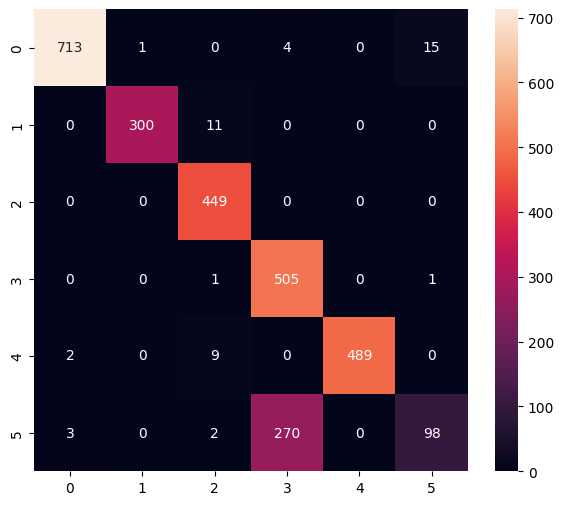

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       733
           1       1.00      0.96      0.98       311
           2       0.95      1.00      0.98       449
           3       0.65      1.00      0.79       507
           4       1.00      0.98      0.99       500
           5       0.86      0.26      0.40       373

    accuracy                           0.89      2873
   macro avg       0.91      0.86      0.85      2873
weighted avg       0.91      0.89      0.87      2873



In [427]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [428]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [429]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_video.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpef3n_07o/assets


INFO:tensorflow:Assets written to: /tmp/tmpef3n_07o/assets
2024-01-15 15:29:04.427412: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-15 15:29:04.427435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-15 15:29:04.427610: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpef3n_07o
2024-01-15 15:29:04.428834: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-15 15:29:04.428848: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpef3n_07o
2024-01-15 15:29:04.435589: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-15 15:29:04.489242: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpef3n_07o
2024-01-15 15:29:04.506894: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

7656

# 推論テスト

In [430]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [431]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [432]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [433]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 860 µs, sys: 53 µs, total: 913 µs
Wall time: 891 µs


In [434]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00086433 0.02200391 0.8500228  0.03724794 0.07138948 0.01847152]
2


2/[ 0.          0.          0.12623274 -0.0887574   0.21104537 -0.22682446
  0.11242604 -0.3096647  -0.02366864 -0.34516767  0.0591716  -0.54043394
  0.00986193 -0.73964494 -0.03353057 -0.877712   -0.07889546 -1.
 -0.09270217 -0.52662724 -0.01577909 -0.4418146   0.04733728 -0.27613413
  0.07495069 -0.20118344 -0.19723865 -0.4398422  -0.09664694 -0.30177516
 -0.01577909 -0.18934911  0.01380671 -0.16765286 -0.27218935 -0.32938856
 -0.16568047 -0.19723865 -0.08086785 -0.11439842 -0.04733728 -0.1183432 ]
2/[-0.          0.         -0.13549618 -0.07824428 -0.24045801 -0.25381678
 -0.19274808 -0.41793892 -0.10305344 -0.52671754 -0.24809161 -0.5152672
 -0.29580152 -0.7519084  -0.33778626 -0.8778626  -0.34923664 -1.
 -0.10305344 -0.52671754 -0.15648855 -0.59732825 -0.17175573 -0.4274809
 -0.14694656 -0.35496184  0.01526718 -0.490458   -0.03816794 -0.44656488
 -0.07251909 -0.29007635 -0.0629771  -0.26335877  0.11259542 -0.4255725
  0.03053435 -0.33396947 -0.         -0.22900763  0.01145038 -0.2

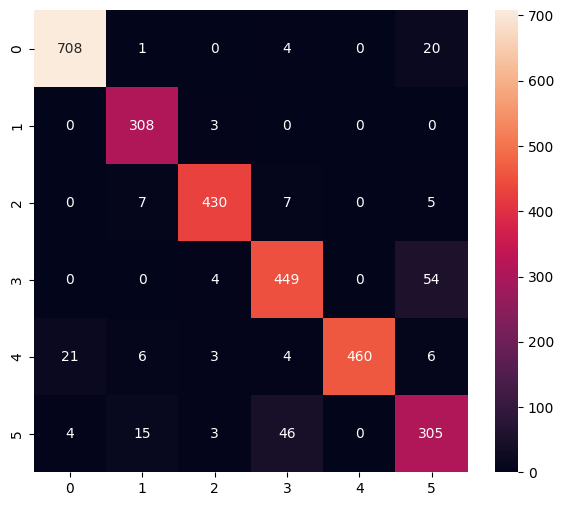

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       733
           1       0.91      0.99      0.95       311
           2       0.97      0.96      0.96       449
           3       0.88      0.89      0.88       507
           4       1.00      0.92      0.96       500
           5       0.78      0.82      0.80       373

    accuracy                           0.93      2873
   macro avg       0.92      0.92      0.92      2873
weighted avg       0.93      0.93      0.93      2873



In [437]:
from model import KeyPointClassifier

keypoint_classifier = KeyPointClassifier()
y_pred2 = []
for x in X_test:
    pred = keypoint_classifier(x)
    y_pred2.append(pred)


print_confusion_matrix(y_test, y_pred2)